<a href="https://colab.research.google.com/github/Oelazab/PCA-Based-Face-Recognition/blob/main/PCA_based_face_recognition_ver1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

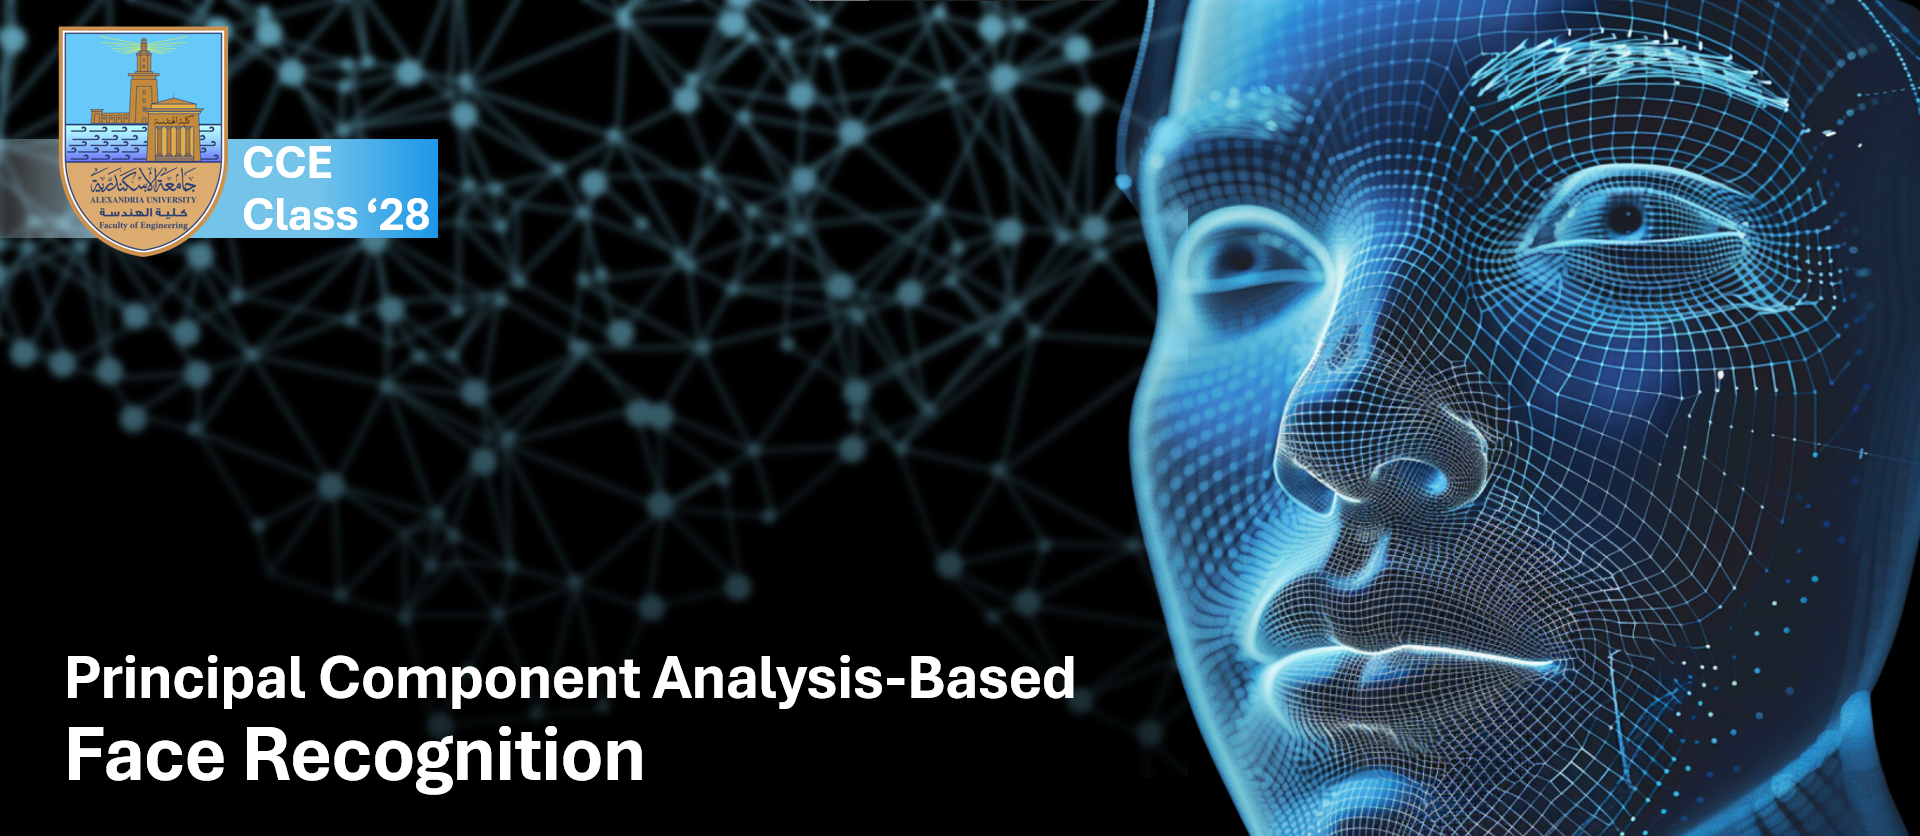

# **Libraries**

In [ ]:
import os                         # Library to work with the file system (folders and files)
import cv2                        # OpenCV library for image processing
import numpy as np                # Library for numerical operations
import matplotlib.pyplot as plt   # Library for plotting images and visualizations

# **Dataset**
### *Load labeled images from a dataset folder*
*Args:*
  * *folder: Path to the dataset containing subfolders for each person.*
  * *target_size: Tuple specifying the desired resolution for resizing.*

Returns:
  * *images: List of processed images as numpy arrays.*
  * *labels: List of numeric labels corresponding to each person.*
  * *label_names: Names of persons corresponding to the labels.*

In [ ]:
# Load the dataset with multiple images per person (labeled images)
def load_dataset(folder, target_size):
    images = []       # To store all image data
    labels = []       # To store numeric labels (e.g., 0, 1, 2 for different people)
    label_names = []  # To store names of individuals in the dataset

    for label_id, subfolder in enumerate(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label_names.append(subfolder)  # Person's name
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, target_size)
                    images.append(img_resized / 255.0)  # Normalize to [0, 1]
                    labels.append(label_id)
    return np.array(images), np.array(labels), label_names

# **Principal Component Analysis**

In [ ]:
# PCA implementation
def perform_pca(data, n_components):
    """
    Perform PCA on the dataset to extract principal components (Eigenfaces).

    Args:
        data: Flattened image data (each row is a flattened image).
        n_components: Number of principal components to retain.

    Returns:
        mean_face: The average face of the dataset.
        eigenfaces: The top principal components (Eigenfaces).
    """
    mean_face = np.mean(data, axis=0)                     # Compute the average face (mean vector)
    data_centered = data - mean_face                      # Center data by subtracting the mean
    cov_matrix = np.cov(data_centered.T)                  # Compute the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) # Eigen decomposition
    sorted_indices = np.argsort(-eigenvalues)             # Sort eigenvalues in descending order
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]# Top eigenvectors
    eigenfaces = top_eigenvectors.T                       # Transpose for easier dot-product operations
    return mean_face, eigenfaces

# **Project data into PCA space**

In [ ]:
# Project data into PCA space
def project_to_pca_space(data, mean_face, eigenfaces):
    """
    Project dataset into the PCA space for dimensionality reduction.

    Args:
        data: Flattened image data.
        mean_face: Mean face of the dataset.
        eigenfaces: Principal components (Eigenfaces).

    Returns:
        projections: Dataset projected into the PCA space.
    """
    data_centered = data - mean_face                  # Subtract the mean to center the data
    projections = np.dot(data_centered, eigenfaces.T) # Project onto PCA components
    return projections

# **Recognize a person**

In [ ]:
# Recognize a person
def recognize_person(test_projection, projections, labels, label_names, threshold=10):
    """
    Recognize a person by finding the minimum distance in the PCA space.

    Args:
        test_projection: PCA projection of the test image.
        projections: PCA projections of the training dataset.
        labels: Numeric labels of the training dataset.
        label_names: Names corresponding to each label.
        threshold: Distance threshold for recognizing "unknown" faces.

    Returns:
        recognized_name: Name of the recognized person or "Unknown".
        min_distance: Distance to the closest match.
    """
    distances = np.linalg.norm(projections - test_projection, axis=1)
    min_distance = np.min(distances)
    if min_distance > threshold:
        return "Unknown", min_distance
    recognized_index = np.argmin(distances)
    return label_names[labels[recognized_index]], min_distance

In [ ]:
# Function to test all images in a folder
def test_all_images_in_folder(folder_path, target_size, mean_face, eigenfaces, projections, labels, label_names, threshold=10):
    """
    Test all images in a folder and display recognition results.

    Args:
        folder_path: Path to the folder containing test images.
        target_size: Tuple specifying image size (height, width).
        mean_face: Mean face vector from PCA.
        eigenfaces: Principal components (Eigenfaces) from PCA.
        projections: PCA projections of training images.
        labels: Numeric labels for training images.
        label_names: Names corresponding to training labels.
        threshold: Distance threshold for recognition.

    Displays:
        A row of images with recognition results as titles.
    """
    test_images = []
    results = []

    # Load all images from the test folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, target_size) / 255.0
            test_images.append((img, img_resized.flatten()))

    # Recognize each image
    for img, img_flat in test_images:
        test_projection = np.dot(img_flat - mean_face, eigenfaces.T)
        recognized_name, distance = recognize_person(test_projection, projections, labels, label_names, threshold)
        results.append((img, recognized_name, distance))

    # Plot results
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    for ax, (img, name, dist) in zip(axes, results):
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{name}\nDist: {dist:.2f}", fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# **LOAD PERFORM PROJECT**

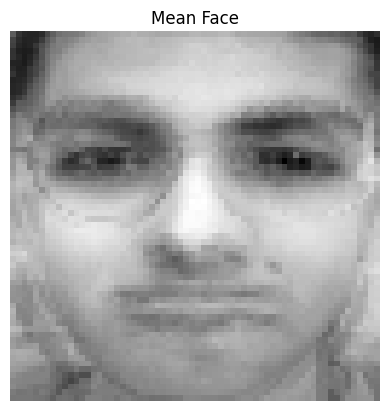

In [ ]:
# Main program
dataset_path = "/content/drive/MyDrive/Projects/Principal Component Analysis-Based Face Recognition/model/dataset"  # Replace with your dataset path
target_size = (64, 64)
n_components = 50  # Number of principal components

# Load dataset
images, labels, label_names = load_dataset(dataset_path, target_size)
data = images.reshape(len(images), -1) # Flatten each image into a single vector

# Perform PCA
mean_face, eigenfaces = perform_pca(data, n_components)

# Project data to PCA space
projections = project_to_pca_space(data, mean_face, eigenfaces)

# Visualize the mean face
plt.imshow(mean_face.reshape(target_size), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

# **Test Dataset**

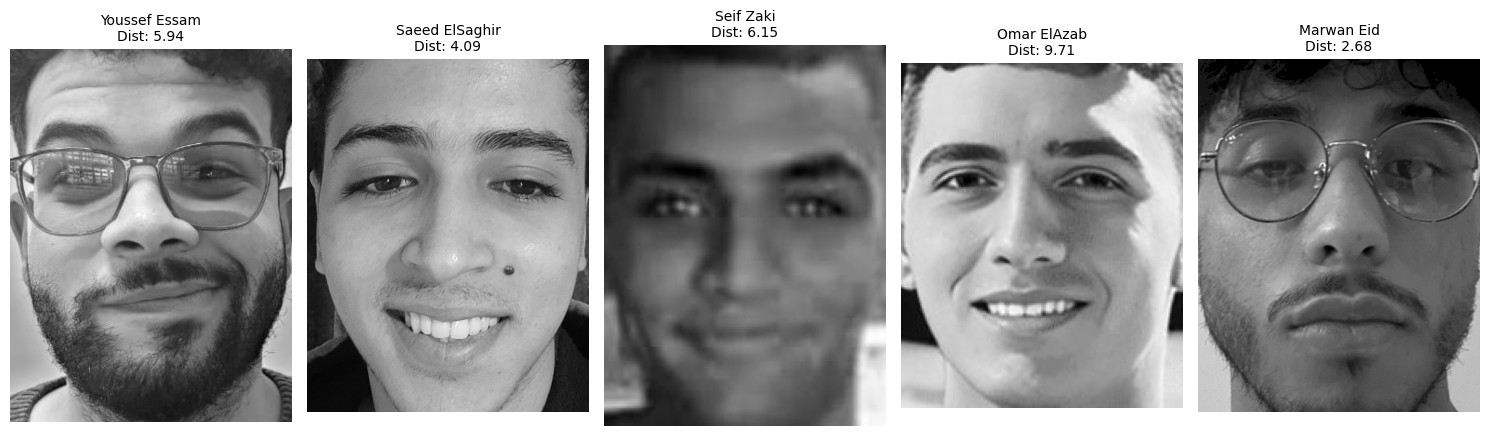

In [ ]:
# Test with a new image
test_image_path = "/content/drive/MyDrive/Projects/Principal Component Analysis-Based Face Recognition/model/test"  # Replace with the test image path
test_folder_path = test_image_path  # Replace with your test images folder
test_all_images_in_folder(test_folder_path, target_size, mean_face, eigenfaces, projections, labels, label_names)